# TODO
1. Envelope 찾기. 각 n에 대한 함수에서.
2. Envelope를 가정하고, 전략 찾기
3. 이것도 엄청난 수준의 근사이므로 그럴듯한 논거가 될 것이다. (fringe 때문에 가정 2의 성립이 사실상 불가능함)

# Section 0. Preparation

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import *
import scipy.signal, scipy.interpolate

from tqdm import tqdm

In [2]:
# Parameters
alpha = 0.25
beta = 0.67
f = 100e6
D = 11.5e3 ** 2 / 1e-6
T = 50e-6

In [3]:
def information0(t):
    return (beta*2*np.pi*t*np.sin(2*np.pi*f*t))**2/(1-(alpha+beta*np.cos(2*np.pi*f*t))**2)

# r belongs to {-1, 1}
def prob(t, n, r, f):
    def integrand(x):
        return 0.5*(1+r*(alpha+beta*np.cos(2*np.pi*x*t)))*1/np.sqrt(4*np.pi*D*T*n)*np.exp(-(x-f)**2/(4*D*T*n))

    n_sig = 10
    return quad(integrand, f-n_sig*np.sqrt(2*D*T*n), f+n_sig*np.sqrt(2*D*T*n))[0]

def dprob(t, n, r, f):
    def integrand(x):
        return 0.5*(1+r*(alpha+beta*np.cos(2*np.pi*x*t)))*1/np.sqrt(4*np.pi*D*T*n)*(x-f)/(2*D*T*n)*np.exp(-(x-f)**2/(4*D*T*n))

    n_sig = 10
    return quad(integrand, f-n_sig*np.sqrt(2*D*T*n), f+n_sig*np.sqrt(2*D*T*n))[0]

def information(t, n=0):

    if n == 0:
        n = 0.001
    # return prob(t, n, 1, f)
    return sum([1/prob(t, n, r, f)*(dprob(t, n, r, f))**2 for r in [-1, 1]])

def upper_envelope(lst):
    x = []
    y = []
    for i, data in enumerate(lst):
        if 0 < i < len(lst)-1:
            if lst[i-1] < data and lst[i+1] < data:
                x.append(i)
                y.append(data)

    func_y = scipy.interpolate.interp1d(x, y, fill_value='extrapolate')

    envelope = []
    for i in range(len(lst)):
         envelope.append(func_y(i))

    return envelope

# Section 1

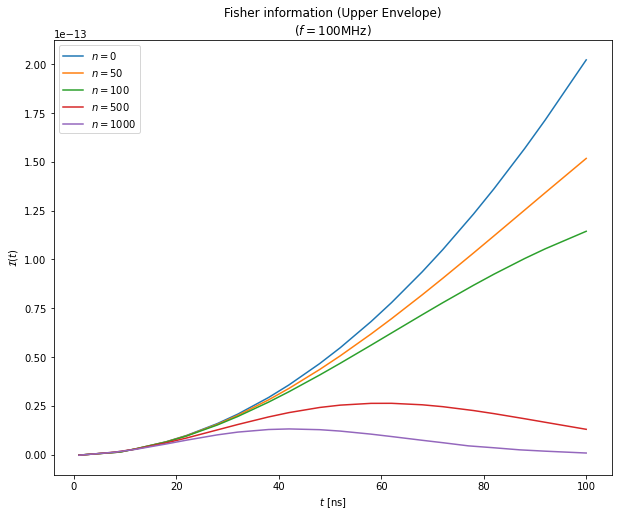

In [12]:
t_list = np.linspace(1e-9, 100e-9, 100)

plt.figure(figsize=(10,8))
plt.title("Fisher information (Upper Envelope)\n($f=100\mathrm{MHz}$)")
for n in (0, 50, 100, 500, 1000):
    if n == 0:
        b_list = [information0(t) for t in t_list]
    else:
        b_list = [information(t, n) for t in t_list]
    plt.plot(t_list*1e9, upper_envelope(b_list), label=f"$n={n}$")
plt.legend()
plt.xlabel("$t$ [ns]")
plt.ylabel("$\mathcal{I}(t)$")
plt.show()

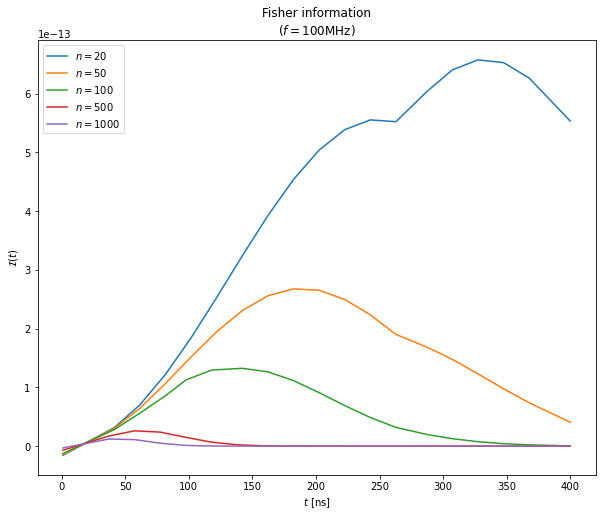

In [14]:
t_list = np.linspace(1e-9, 400e-9, 100)

plt.figure(figsize=(10,8))
plt.title("Fisher information\n($f=100\mathrm{MHz}$)")
for n in (20, 50, 100, 500, 1000):
    if n == 0:
        b_list = [information0(t) for t in t_list]
    else:
        b_list = [information(t, n) for t in t_list]
    plt.plot(t_list*1e9, upper_envelope(b_list), label=f"$n={n}$")
plt.legend()
plt.xlabel("$t$ [ns]")
plt.ylabel("$\mathcal{I}(t)$")
plt.show()

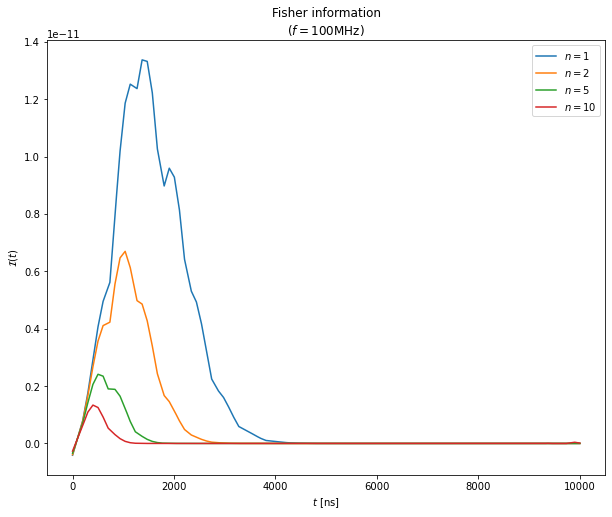

In [15]:
t_list = np.linspace(1e-9, 10e-6, 300)

plt.figure(figsize=(10,8))
plt.title("Fisher information\n($f=100\mathrm{MHz}$)")
for n in (1, 2, 5, 10):
    if n == 0:
        b_list = [information0(t) for t in t_list]
    else:
        b_list = [information(t, n) for t in t_list]
    plt.plot(t_list*1e9, upper_envelope(b_list), label=f"$n={n}$")
plt.legend()
plt.xlabel("$t$ [ns]")
plt.ylabel("$\mathcal{I}(t)$")
plt.show()

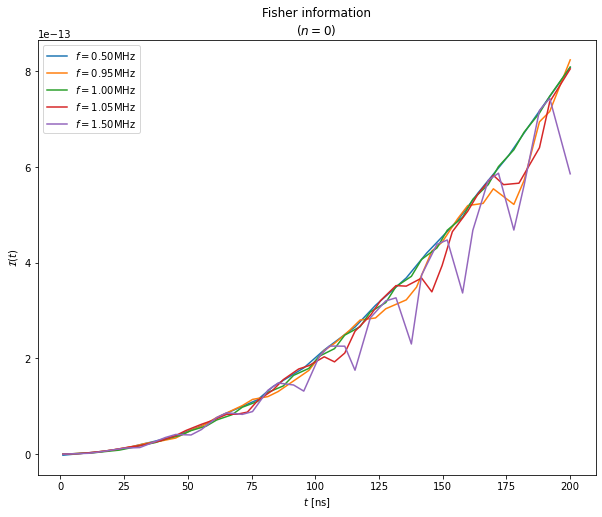

In [16]:
t_list = np.linspace(1e-9, 200e-9, 100)

plt.figure(figsize=(10,8))
plt.title("Fisher information\n($n=0$)")
for f in (50e6, 95e6, 100e6, 105e6, 150e6):
    b_list = [information0(t) for t in t_list]
    plt.plot(t_list*1e9, upper_envelope(b_list), label=f"$f={f/100e6:.2f}$MHz")
f = 100e6 # Don't forget this line
plt.legend()
plt.xlabel("$t$ [ns]")
plt.ylabel("$\mathcal{I}(t)$")

plt.show()

# Section 2

In [78]:
def find_maxinfo_and_t(n):
    info_max = 0
    t_max = 0
    for t in np.linspace(100e-9, 3000e-9/n*1.4, 273):
        info = information(t, n)
        if info > info_max:
            info_max = info
            t_max = t
    
    return t_max, info_max

data = []
for n in tqdm(range(1, 101, 2)):
    data.append((n,) + find_maxinfo_and_t(n))
zip_data = list(zip(*data))

100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


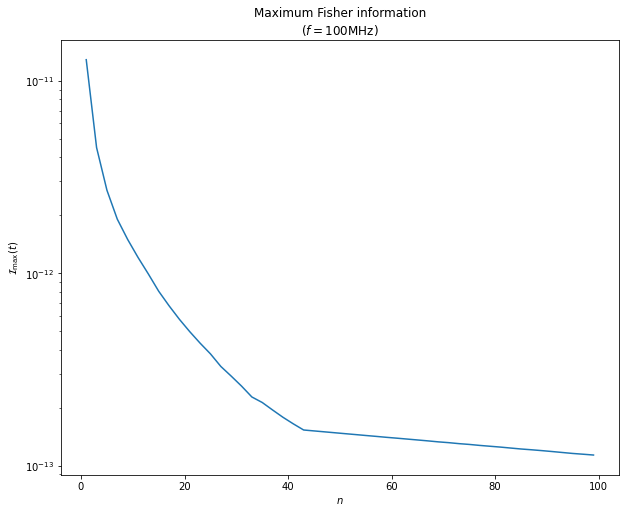

In [79]:
plt.figure(figsize=(10,8))
plt.title("Maximum Fisher information\n($f=100$MHz)")
plt.semilogy(zip_data[0], zip_data[2])
plt.xlabel("$n$")
plt.ylabel("$\mathcal{I}_{\mathrm{max}}(t)$")
plt.show()

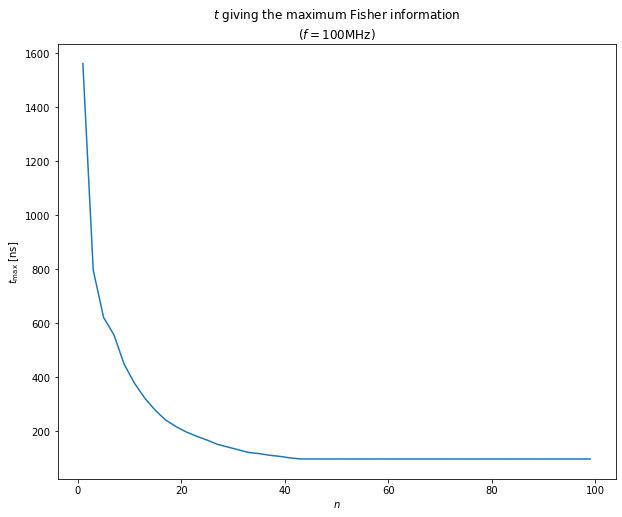

In [80]:
plt.figure(figsize=(10,8))
plt.title("$t$ giving the maximum Fisher information\n($f=100$MHz)")
plt.plot(zip_data[0], np.multiply(zip_data[1], 1e9))
plt.xlabel("$n$")
plt.ylabel("$t_\mathrm{max}$ [ns]")
plt.show()

In [81]:
def find_maxinfo_and_t(n):
    info_max = 0
    t_max = 0
    for t in np.linspace(30e-9, 200e-9, 300):
        info = information(t, n)
        if info > info_max:
            info_max = info
            t_max = t
    
    return t_max, info_max

data = []
for n in tqdm(range(1, 101, 2)):
    data.append((n,) + find_maxinfo_and_t(n))
zip_data = list(zip(*data))

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


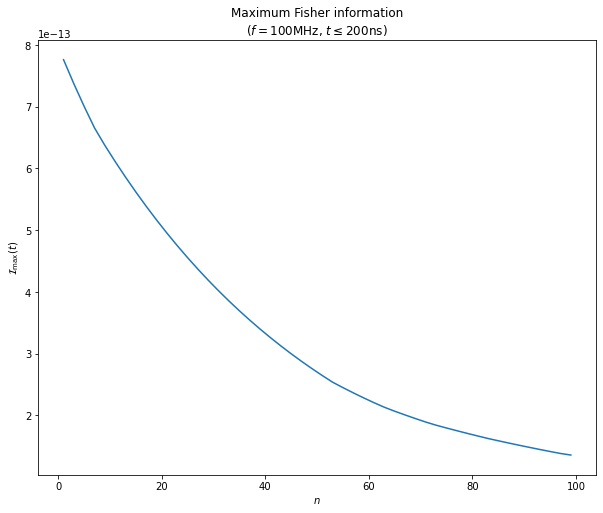

In [83]:
plt.figure(figsize=(10,8))
plt.title("Maximum Fisher information\n($f=100$MHz, $t \leq 200$ns)")
plt.plot(zip_data[0], zip_data[2])
plt.xlabel("$n$")
plt.ylabel("$\mathcal{I}_{\mathrm{max}}(t)$")
plt.show()

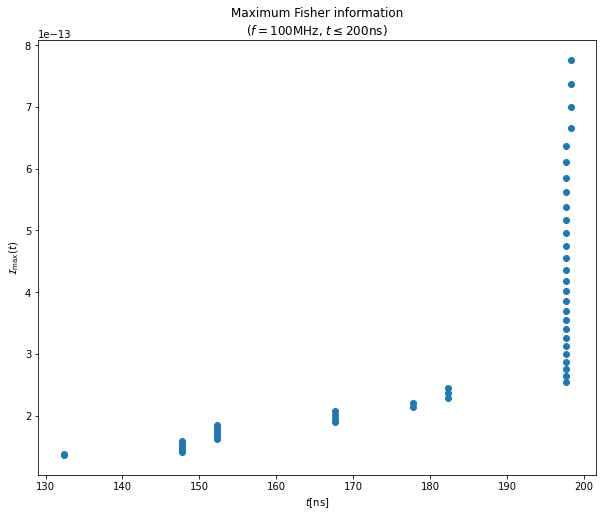

In [84]:
plt.figure(figsize=(10,8))
plt.title("Maximum Fisher information\n($f=100$MHz, $t \leq 200$ns)")
plt.plot(np.multiply(zip_data[1], 1e9), zip_data[2], linestyle='none', marker='o')
plt.xlabel("$t$[ns]")
plt.ylabel("$\mathcal{I}_{\mathrm{max}}(t)$")
plt.show()